In [85]:
pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [86]:
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.api as sm
from econml.dml import CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [87]:
path = "../input/processed.cleveland.data"
df = pd.read_csv(path, sep=",", header=None)
print("\nVista preliminar:")
print(df.head(10))


Vista preliminar:
     0    1    2      3      4    5    6      7    8    9    10   11   12  13
0  63.0  1.0  1.0  145.0  233.0  1.0  2.0  150.0  0.0  2.3  3.0  0.0  6.0   0
1  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0   2
2  67.0  1.0  4.0  120.0  229.0  0.0  2.0  129.0  1.0  2.6  2.0  2.0  7.0   1
3  37.0  1.0  3.0  130.0  250.0  0.0  0.0  187.0  0.0  3.5  3.0  0.0  3.0   0
4  41.0  0.0  2.0  130.0  204.0  0.0  2.0  172.0  0.0  1.4  1.0  0.0  3.0   0
5  56.0  1.0  2.0  120.0  236.0  0.0  0.0  178.0  0.0  0.8  1.0  0.0  3.0   0
6  62.0  0.0  4.0  140.0  268.0  0.0  2.0  160.0  0.0  3.6  3.0  2.0  3.0   3
7  57.0  0.0  4.0  120.0  354.0  0.0  0.0  163.0  1.0  0.6  1.0  0.0  3.0   0
8  63.0  1.0  4.0  130.0  254.0  0.0  2.0  147.0  0.0  1.4  2.0  1.0  7.0   2
9  53.0  1.0  4.0  140.0  203.0  1.0  2.0  155.0  1.0  3.1  3.0  0.0  7.0   1


In [88]:
df.rename(columns={
    0: 'age', 1: 'sex', 2: 'cp', 3: 'restbp', 4: 'chol',
    5: 'fbs', 6: 'restecg', 7: 'thalach', 8: 'exang',
    9: 'oldpeak', 10: 'slope', 11: 'ca', 12: 'thal', 13: 'hd'
}, inplace=True)

In [89]:
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [90]:
df.isnull().sum()

age        0
sex        0
cp         0
restbp     0
chol       0
fbs        0
restecg    0
thalach    0
exang      0
oldpeak    0
slope      0
ca         0
thal       0
hd         0
dtype: int64

In [92]:
# Data limpia
df.to_csv("../output/cleaned_cleveland_data.csv", index=False)

In [93]:
# Crear variable binaria de tratamiento T (asignación aleatoria) 0.5
np.random.seed(123)
df["T"] = np.random.binomial(1, 0.5, size=len(df)) 

In [94]:
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd,T
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,1
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,1
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1


In [95]:
# Crear variable de resultado Y que muestre el efecto del tratamiento más otras covariables y ruido
rs = np.random.RandomState(123)
epsilon = rs.normal(loc=0.0, scale=1.0, size=len(df))
# --- Outcome según la regla del enunciado ---
df["Y"] = (
    (1 + 0.05*df["age"] + 0.3*df["sex"] + 0.2*df["restbp"]) * df["T"]
    + 0.5*df["oldpeak"]
    + epsilon
)
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd,T,Y
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,1,33.514369
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,0,1.747345
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,0,1.582978
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,1,29.393705
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,29.171400


In [96]:
import statsmodels.formula.api as smf
ols_model = smf.ols('Y ~ T + age + sex + restbp + oldpeak', data=df).fit()
print(ols_model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.4834      1.081    -11.548      0.000     -14.611     -10.356
T             30.2015      0.239    126.597      0.000      29.732      30.671
age            0.0221      0.014      1.574      0.117      -0.006       0.050
sex            0.2218      0.259      0.855      0.393      -0.289       0.732
restbp         0.0843      0.007     11.787      0.000       0.070       0.098
oldpeak        0.5303      0.107      4.960      0.000       0.320       0.741


In [97]:
np.random.seed(123)
# Definir variables
Y = df['Y']
T = df['T']
X = df[['age', 'sex', 'restbp', 'oldpeak']]

# Ajustar bosque causal
forest = CausalForestDML(
    n_estimators=500,
    max_depth=5,
    random_state=123
)
forest.fit(Y=Y, T=T, X=X)

# Árbol interpretativo con profundidad 2
intrp = SingleTreeCateInterpreter(max_depth=2)
intrp.interpret(forest, X)


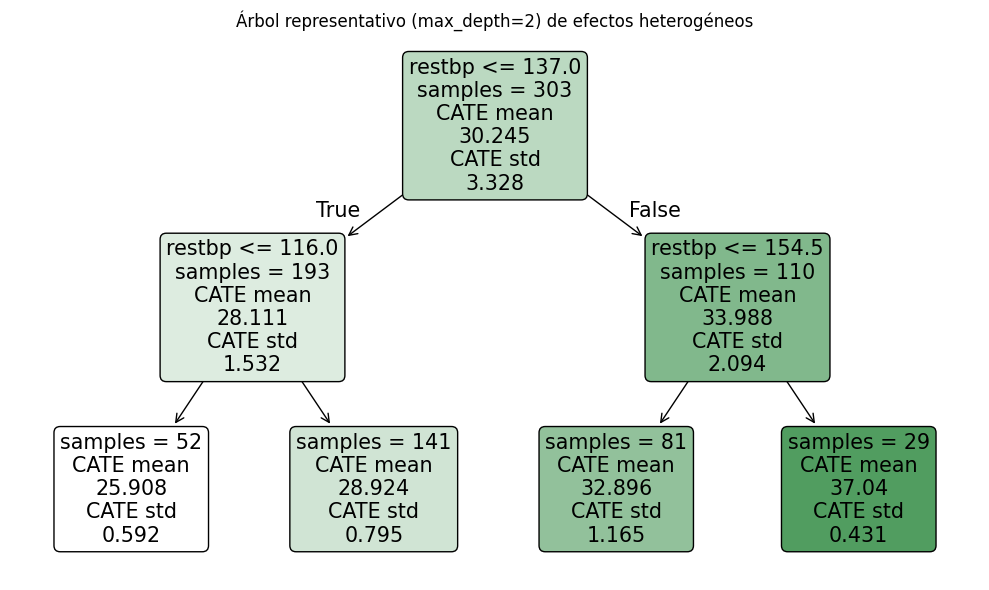

In [98]:
# Graficar árbol
plt.figure(figsize=(10, 6))
intrp.plot(feature_names=['age', 'sex', 'restbp', 'oldpeak'])
plt.title("Árbol representativo (max_depth=2) de efectos heterogéneos")
plt.tight_layout()
plt.savefig("../output/causal_forest_tree.png", dpi=200)
plt.show()

#### Interpretación 
El árbol muestra cómo el efecto estimado del tratamiento (es decir, cuánto mejora la salud cardiovascular promedio tras el programa) varía según la presión arterial en reposo (restbp).
El modelo divide primero por la presión arterial es decir que las personas con presión baja o normal (≤137 mmHg) presentan un efecto medio del tratamiento de aprox. 28.1, lo que indica una mejora moderada tras la intervención.
##### Subgrupo izquierdo (restbp ≤ 116 mmHg)
Entre quienes tienen la presión más baja, el efecto promedio cae a ≈25.9, lo que sugiere que el tratamiento tiene menor impacto en individuos con presión muy controlada o normal.
##### Subgrupo derecho del nodo raíz (restbp > 137 mmHg)
Los individuos con presión arterial elevada muestran efectos mucho más altos.
Esto implica que el programa beneficia más a personas con hipertensión o presión en reposo alta, posiblemente porque estos pacientes parten de una peor condición cardiovascular y tienen mayor margen de mejora tras la intervención.

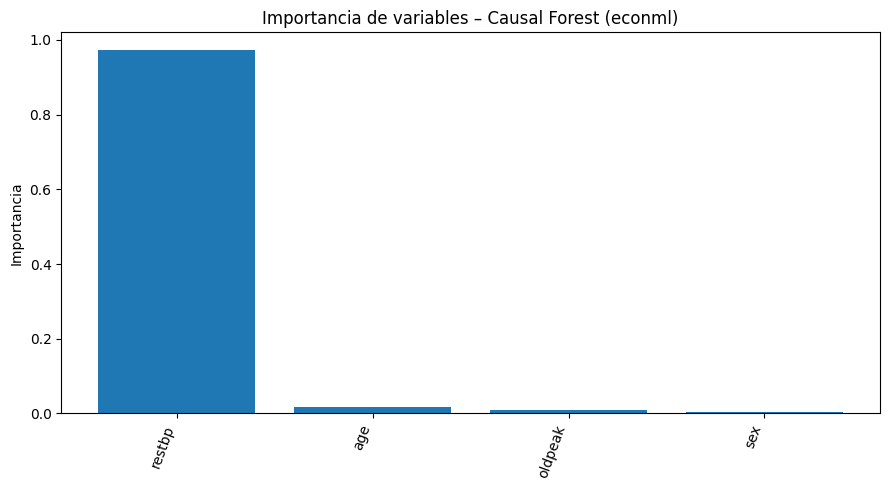

,feature,importance
0,restbp,0.971859
1,age,0.016503
2,oldpeak,0.008700
3,sex,0.002938


In [99]:
importances = forest.feature_importances_          # array (len = n_features)
feat_names = np.array(X.columns)
# Ordenar de mayor a menor
order = np.argsort(importances)[::-1]
imp_sorted = importances[order]
names_sorted = feat_names[order]

# Gráfico
plt.figure(figsize=(9, 5))
plt.bar(range(len(imp_sorted)), imp_sorted)
plt.xticks(range(len(imp_sorted)), names_sorted, rotation=70, ha="right")
plt.ylabel("Importancia")
plt.title("Importancia de variables – Causal Forest (econml)")
plt.tight_layout()
plt.savefig("../output/cate_feature_importance.png", dpi=200)
plt.show()

# (opcional) Top 10 en tabla
topk = 10
pd.DataFrame({"feature": names_sorted[:topk], "importance": imp_sorted[:topk]})

In [100]:
# Obtener los efectos individuales (CATE)
tau_hat = forest.effect(X)

# Estandarizar todas las covariables
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [101]:
# Dividir el efecto estimado en tres terciles
X_std["tercil_cate"] = pd.qcut(tau_hat, q=3, labels=["bajo", "medio", "alto"])

In [102]:

# Calcular la media de cada covariable dentro de cada tercil
mean_by_tercile = X_std.groupby("tercil_cate")[X.columns].mean()

/var/folders/zs/1pxmnc6s7b7_ft4ym5rcy30r0000gn/T/ipykernel_94024/3485197910.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_tercile = X_std.groupby("tercil_cate")[X.columns].mean()


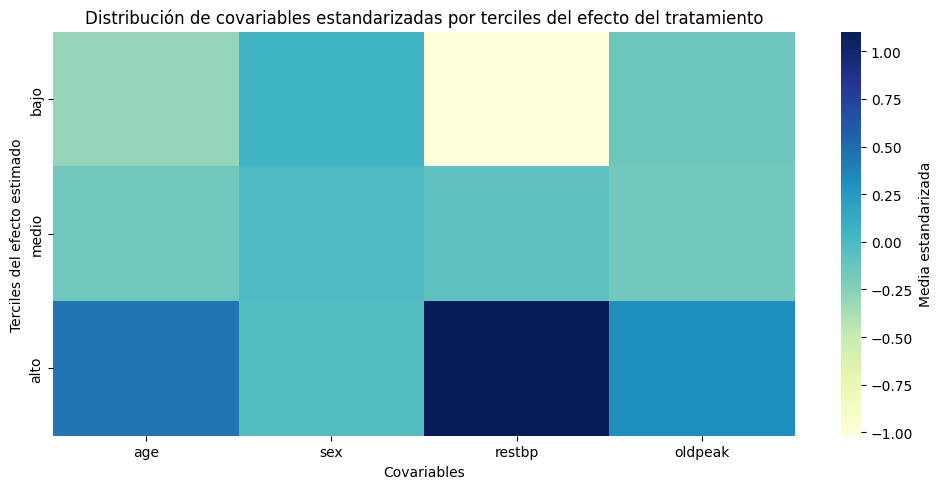

In [103]:
# Graficar el heatmap
plt.figure(figsize=(max(10, len(X.columns)*0.5), 5))
sns.heatmap(mean_by_tercile, cmap="YlGnBu", cbar_kws={"label": "Media estandarizada"})
plt.title("Distribución de covariables estandarizadas por terciles del efecto del tratamiento")
plt.xlabel("Covariables")
plt.ylabel("Terciles del efecto estimado")
plt.tight_layout()
plt.savefig("../output/cate_covariates_heatmap.png", dpi=200)
plt.show()
